In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [102]:
def generate_sequence(sequence_length, transition_probabilities, num_states, critical_states):
#     init_state = np.random.randint(0, num_states , 1)
    observation_sequence = []
    init_state=3
    current_state = init_state#init state

# Generate a single sample from the multivariate normal distribution
    for jj in range(sequence_length):
        mean = [current_state, 0]
        cov = [[1, 0], [0, 2]]
        observation = np.random.multivariate_normal(mean, cov)
        observation_sequence.append(observation)
        current_state = np.random.choice(range(num_states), p=transition_probabilities[current_state])
    return np.array(observation_sequence), np.sum(np.isin(state_sequence, critical_states)), state_sequence

In [103]:
# Define the number of sequences and the length of each sequence
num_sequences = 1000
sequence_length = 50
num_critical_states = 5
num_states=20

# Define the transition probabilities matrix
transition_probabilities = np.random.rand(num_states, num_states)
transition_probabilities /= np.sum(transition_probabilities, axis=1, keepdims=True)

# Define the critical states
critical_states = np.array([0, 18, 19])
transition_probabilities[:, critical_states] *= 0.05
transition_probabilities /= np.sum(transition_probabilities, axis=1, keepdims=True)

# Generate the dataset of sequences
dataset = []
outcomes = []
state_seqs_list = []
for _ in range(num_sequences):
    sequence, num_critical_transitions, state_sequence = generate_sequence(sequence_length, 
                                                                           transition_probabilities, 
                                                                           num_states,
                                                                           critical_states)
    dataset.append(sequence)
    
    # Determine the outcome based on the number of transitions to critical states
    if num_critical_transitions >= 10:
        outcome = "High"
    elif num_critical_transitions >= 5:
        outcome = "Medium"
    else:
        outcome = "Low"
    
    outcomes.append(outcome)
    state_seqs_list.append(state_sequence)

# Convert the dataset and outcomes to arrays
dataset = np.array(dataset)
outcomes = np.array(outcomes)

# Print the shape of the dataset and outcomes
print("Dataset shape:", dataset.shape)
print("Outcomes shape:", outcomes.shape)

Dataset shape: (1000, 50, 2)
Outcomes shape: (1000,)


## Visualize sequences

<Figure size 720x432 with 0 Axes>

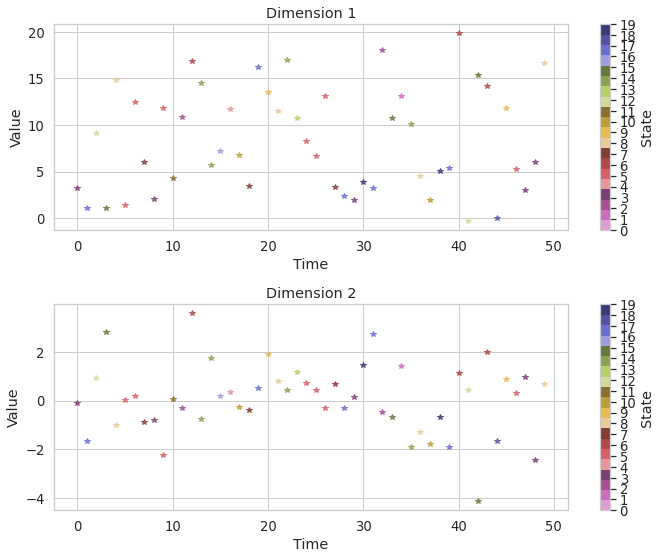

In [106]:
# Plot the sequence with state overlay
cmap = plt.get_cmap("tab20b_r", num_states)
plt.figure(figsize=(10, 6))

seq_id=0
state_sequence = state_seqs_list[seq_id]
observation_sequence = dataset[seq_id]

# Create subplots for each dimension
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
sns.set_context('notebook', font_scale=1.2)
sns.set_style('whitegrid')

# Plot each dimension separately
for i in range(2):
    axs[i].set_title(f"Dimension {i+1}")
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel("Value")
    
    # plot sequence with state overlay
    for j in range(num_states):
        idx = np.where(state_sequence == j)
        color = cmap(j / (num_states - 1))  # Normalize state value between 0 and 1
        axs[i].plot(idx[0], np.squeeze(observation_sequence[idx, i]), marker='*', linestyle='None', 
                    color=color, alpha=0.8)

    # Add colorbar for state values
    norm = plt.Normalize(0, num_states-1)
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    cbar = plt.colorbar(sm, ax=axs[i], ticks=range(num_states))
    cbar.set_label('State')

plt.tight_layout()

# Show the plot
plt.show()

In [105]:
state_sequence

array([ 3, 17, 12, 15,  8,  5,  5,  7,  3,  5, 11,  2,  6, 14, 14, 16,  4,
       10,  7, 17,  9,  8, 14, 13,  5,  5,  5,  7, 17,  3, 19, 17,  2, 15,
        1, 14,  8, 10, 19, 17,  6, 12, 15,  6, 18,  9,  5,  3,  3,  8])

In [96]:
observation = np.zeros(2)
observation[1].shape

()

In [111]:
(1-0.04)

0.96

In [112]:
0.96/16

0.06